In [1]:
import os
import shutil
import glob
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import splitfolders

import tensorflow as tf

tf.__version__

'2.5.0'

# Split data

In [2]:
should_prepare_data = True

In [3]:
def prepare_data():
    
    dirpaths = []
    class_names = []
    
    # generate list with roots for folders
    for dirpath, folder, _ in os.walk('./data/flowers/'):
        dirpaths.append(dirpath)
        class_names.append(folder)
    
    class_names = class_names[0]
        
    j = 0
    
    # loop through roots of image folders
    for dirpath in dirpaths[1:]:

        dst_dir = './data/input_flowers'

        if not os.path.exists(dst_dir):
            os.mkdir(dst_dir)

        i = 1  # no. of image

        for jpg_file in glob.iglob(os.path.join(dirpath, '*.jpg')):

            img_path = os.path.join(dst_dir, class_names[j])

            if not os.path.exists(img_path):
                os.mkdir(img_path)

            new_name = f'{class_names[j]}/{j}_{i}.jpg'

            shutil.copy(jpg_file, os.path.join(dst_dir, new_name))

            i += 1

        j += 1

    # split images to train/val/test folders
    splitfolders.ratio('./data/input_flowers', output='./data/output_flowers', seed=1337, ratio=(.7, .15, .15))
    
    return class_names

In [4]:
if should_prepare_data:
    prepare_data()

Copying files: 4317 files [00:00, 6990.73 files/s]


# Define train/val/test sets

In [39]:
batch_size = 32
img_height = 280
img_width = 280

data_dir = './data/output_flowers/train/'
val_dir = './data/output_flowers/val/'
test_dir = './data/output_flowers/test/'

In [40]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )



Found 3019 files belonging to 5 classes.


In [41]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )


Found 644 files belonging to 5 classes.


In [42]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )


Found 654 files belonging to 5 classes.


In [43]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

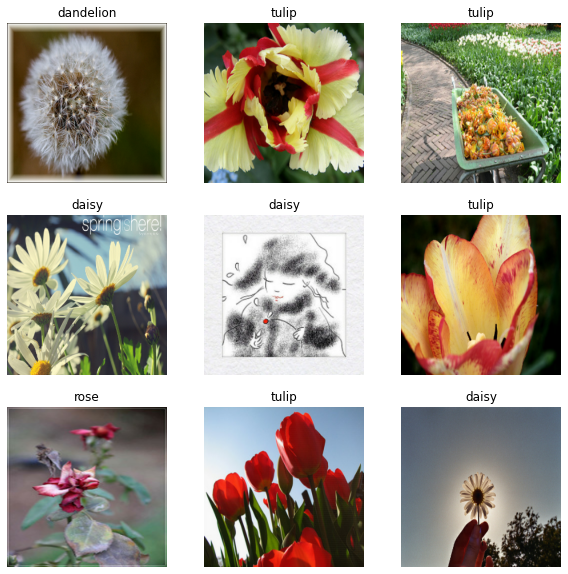

In [44]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


# Deep learning model

In [45]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [46]:
def get_model(num_classes):
    model = tf.keras.Sequential([

        tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        
        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        
        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer='l2'),
        layers.Dense(128, activation='relu', kernel_regularizer='l2'),
        layers.Dense(num_classes)  
    ])
    
    return model

model = get_model(5)
    
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_12 (Rescaling)     (None, 280, 280, 3)       0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 280, 280, 64)      1792      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 140, 140, 64)      0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 140, 140, 64)      0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 140, 140, 64)      36928     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 70, 70, 64)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 70, 70, 64)      

In [47]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/10
95/95 [==============================] - 14s 127ms/step - loss: 2.9544 - accuracy: 0.2435 - val_loss: 1.8103 - val_accuracy: 0.2314
Epoch 2/10
95/95 [==============================] - 11s 113ms/step - loss: 1.5966 - accuracy: 0.3630 - val_loss: 1.5048 - val_accuracy: 0.4053
Epoch 3/10
95/95 [==============================] - 11s 112ms/step - loss: 1.3382 - accuracy: 0.4402 - val_loss: 1.4583 - val_accuracy: 0.4084
Epoch 4/10
95/95 [==============================] - 11s 112ms/step - loss: 1.2587 - accuracy: 0.4770 - val_loss: 1.3416 - val_accuracy: 0.4084
Epoch 5/10
95/95 [==============================] - 11s 113ms/step - loss: 1.2112 - accuracy: 0.5104 - val_loss: 1.6883 - val_accuracy: 0.3525
Epoch 6/10
95/95 [==============================] - 11s 112ms/step - loss: 1.1804 - accuracy: 0.5449 - val_loss: 1.2260 - val_accuracy: 0.5497
Epoch 7/10
95/95 [==============================] - 11s 112ms/step - loss: 1.1239 - accuracy: 0.5714 - val_loss: 1.1541 - val_accuracy: 0.5295

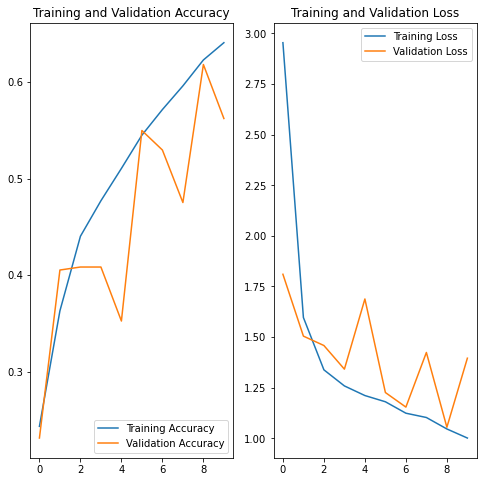

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
model.evaluate(test_ds)

21/21 [==============================] - 1s 31ms/step - loss: 1.2833 - accuracy: 0.5979


[1.2833435535430908, 0.5978593230247498]